### SETTINGS & LIBRARY

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from ultralytics import YOLO
import pandas as pd

IMAGE_PATH = r"C:\Users\dolap\OneDrive\Documents\DOLAPO\data-analysis\photoquadrats_analysis\img\sample_img.JPG"
MODEL_PATH = r"C:\Users\dolap\OneDrive\Documents\DOLAPO\data-analysis\photoquadrats_analysis\model\best.pt"
CONFIDENCE_THRESHOLD = 0.5
GRID_SHAPE = (4, 4)
OUTPUT_VIZ = "quadrat_analysis.png"
OUTPUT_EXCEL = "grid_analysis_report.xlsx"

#### HELPER FUNCTION

In [2]:
def grid_lines(image, grid_shape, color=(0, 255, 0), thickness=1):
    """Draw grid on image."""
    img_height, img_width = image.shape[:2]
    rows, cols = grid_shape
    row_height = img_height // rows
    col_width = img_width // cols

    for i in range(1, rows):
        y = i * row_height
        cv.line(image, (0, y), (img_width, y), color, thickness)

    for j in range(1, cols):
        x = j * col_width
        cv.line(image, (x, 0), (x, img_height), color, thickness)

    return image

In [3]:
def get_class_colors(num_classes):
    """Generate distinct colors for each class by ID."""
    colors = {
        0: (0, 255, 0),      # Green
        1: (255, 0, 0),      # Blue
        2: (0, 0, 255),      # Red
        3: (255, 255, 0),    # Cyan
        4: (255, 0, 255),    # Magenta
        5: (0, 255, 255),    # Yellow
        6: (128, 255, 0),    # Spring Green
        7: (255, 128, 0),    # Orange
        8: (128, 0, 255),    # Purple
        9: (0, 128, 255),    # Orange-Red
    }
    return {i: colors.get(i, colors[i % 10]) for i in range(num_classes)}

In [4]:
def calculate_segmentation_per_grid(image, grid_shape, masks, results):
    """Calculate segmentation area per grid cell with per-class masks."""
    img_height, img_width = image.shape[:2]
    rows, cols = grid_shape
    row_height = img_height // rows
    col_width = img_width // cols

    grid_areas = {}
    grid_detections = {}
    class_masks = {}
    
    for i in range(rows):
        for j in range(cols):
            grid_areas[(i, j)] = {}
            grid_detections[(i, j)] = []

    # Create separate masks for each class
    class_names = results[0].names
    for class_id in range(len(class_names)):
        class_masks[class_id] = np.zeros((img_height, img_width), dtype=np.uint8)

    # Process masks by class
    if results[0].masks is not None:
        for mask_idx in range(len(results[0].masks.data)):
            mask = results[0].masks.data[mask_idx]
            class_id = int(results[0].boxes.cls[mask_idx].item())
            
            # Resize mask to image dimensions
            mask_np = mask.cpu().numpy().astype(np.float32)
            if mask_np.shape != (img_height, img_width):
                mask_resized = cv.resize(mask_np, (img_width, img_height), interpolation=cv.INTER_LINEAR)
            else:
                mask_resized = mask_np
            
            # Normalize to 0-255
            mask_resized = (mask_resized * 255).astype(np.uint8)
            
            # Add this mask to the class mask
            class_masks[class_id] = cv.bitwise_or(class_masks[class_id], mask_resized)
            
            print(f"  Mask {mask_idx}: Class ID {class_id}")

    # Calculate coverage per grid cell per class
    for class_id in range(len(class_names)):
        class_name = class_names[class_id]
        mask = class_masks[class_id]
        
        for i in range(rows):
            for j in range(cols):
                y_start = i * row_height
                y_end = (i + 1) * row_height
                x_start = j * col_width
                x_end = (j + 1) * col_width

                grid_mask = mask[y_start:y_end, x_start:x_end]
                segmented_pixels = np.sum(grid_mask > 0)
                grid_cell_area = (y_end - y_start) * (x_end - x_start)
                percentage_coverage = (segmented_pixels / grid_cell_area) * 100
                
                if percentage_coverage > 0:
                    grid_areas[(i, j)][class_name] = percentage_coverage

    # Track detections per grid cell
    if results[0].boxes is not None:
        boxes = results[0].boxes
        for box_idx, box in enumerate(boxes):
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            center_x = int((x1 + x2) / 2)
            center_y = int((y1 + y2) / 2)

            grid_row = center_y // row_height
            grid_col = center_x // col_width

            if grid_row < rows and grid_col < cols:
                class_id = int(box.cls[0].item())
                confidence = float(box.conf[0].item())
                class_name = class_names[class_id]

                grid_detections[(grid_row, grid_col)].append({
                    'class': class_name,
                    'confidence': confidence,
                    'box': (int(x1), int(y1), int(x2), int(y2))
                })

    return grid_areas, grid_detections, class_masks

In [5]:
def visualize_results(image, grid_shape, grid_areas, grid_detections, class_masks, class_colors):
    """Visualize segmentation with different colors per class."""
    img_height, img_width = image.shape[:2]
    rows, cols = grid_shape
    row_height = img_height // rows
    col_width = img_width // cols

    viz_img = image.copy()
    overlay = viz_img.copy()

    # Create overlay with each class getting its unique color
    for class_id, mask in class_masks.items():
        color = class_colors.get(class_id, (0, 255, 0))
        overlay[mask > 0] = color

    # Blend overlay with original image once
    alpha = 0.4
    viz_img = cv.addWeighted(viz_img, 1 - alpha, overlay, alpha, 0)

    # Draw grid lines
    viz_img = grid_lines(viz_img, grid_shape, color=(255, 255, 255), thickness=2)

    # Add percentage text to each grid cell
    font = cv.FONT_HERSHEY_SIMPLEX
    font_scale = 1.6
    thickness = 4
    text_color = (255, 255, 0)
    bg_color = (0, 0, 0)
    line_height = 50

    for i in range(rows):
        for j in range(cols):
            y_start = i * row_height
            x_start = j * col_width

            # Get all classes and their coverages for this cell
            classes_in_cell = grid_areas[(i, j)]
            
            if classes_in_cell:
                text_lines = [f"{cls}: {cov:.1f}%" for cls, cov in classes_in_cell.items()]
            else:
                text_lines = ["Bare"]

            # Calculate available height in grid cell
            available_height = row_height - 10
            max_lines = available_height // line_height
            text_lines = text_lines[:max_lines]  # Truncate if too many

            # Start position (top-left corner with padding)
            y_offset = y_start + line_height

            for text in text_lines:
                text_size = cv.getTextSize(text, font, font_scale, thickness)[0]
                text_width = text_size[0]
                
                # Ensure text doesn't go out of bounds horizontally
                text_x = max(x_start + 3, min(x_start + col_width - text_width - 3, x_start + 3))
                text_y = y_offset

                # Draw background rectangle
                cv.rectangle(viz_img,
                            (text_x - 3, text_y - text_size[1] - 2),
                            (text_x + text_width + 3, text_y + 2),
                            bg_color, -1)
                
                # Draw text
                cv.putText(viz_img, text, (text_x, text_y),
                          font, font_scale, text_color, thickness)
                
                y_offset += line_height

    return viz_img

In [6]:
def create_excel_report(grid_shape, grid_areas, grid_detections, class_names, output_path=OUTPUT_EXCEL):
    """Create Excel report with grid analysis data."""
    rows, cols = grid_shape
    data = []

    for i in range(rows):
        for j in range(cols):
            coverage_dict = grid_areas[(i, j)]
            detections = grid_detections[(i, j)]

            row_data = {
                'Grid Row': i,
                'Grid Column': j,
                'Total Coverage (%)': round(sum(coverage_dict.values()), 2),
            }

            # Add per-class coverage
            for class_name in class_names:
                row_data[f'{class_name} Coverage (%)'] = round(coverage_dict.get(class_name, 0), 2)

            row_data['Total Detections'] = len(detections)

            # Add detection details
            for det_idx, det in enumerate(detections):
                row_data[f'Det_{det_idx+1}_Class'] = det['class']
                row_data[f'Det_{det_idx+1}_Confidence'] = round(det['confidence'], 4)

            data.append(row_data)

    df = pd.DataFrame(data)
    df.to_excel(output_path, sheet_name='Grid Analysis', index=False)
    print(f"Excel report saved to: {output_path}")
    return df

#### WORKFLOW

In [7]:
print("Loading image...")
img = cv.imread(IMAGE_PATH)
if img is None:
    print(f"Error: Could not load image from {IMAGE_PATH}")
    exit(1)

print("Loading model...")
model = YOLO(MODEL_PATH)

# Debug: Print model classes
print(f"Model classes: {model.names}")
print(f"Total classes in model: {len(model.names)}")

print(f"Running inference (confidence threshold: {CONFIDENCE_THRESHOLD})...")
results = model(img, conf=CONFIDENCE_THRESHOLD)

# Get class names and colors
class_names = results[0].names
num_classes = len(class_names)
class_colors = get_class_colors(num_classes)

# Debug: Print detected classes
print(f"\nDetected classes and their IDs:")
if results[0].boxes is not None:
    for box in results[0].boxes:
        class_id = int(box.cls[0].item())
        class_name = class_names[class_id]
        print(f"  Class ID {class_id}: {class_name}")
else:
    print("  No detections found!")

print("Calculating segmentation per grid...")
grid_areas, grid_detections, class_masks = calculate_segmentation_per_grid(
    img, GRID_SHAPE, results[0].masks, results
)

# Print results
print(f"\nSegmentation coverage per grid cell:")
print("-" * 80)
for (row, col) in sorted(grid_areas.keys()):
    print(f"\nGrid ({row}, {col}):")
    for class_name, coverage in grid_areas[(row, col)].items():
        print(f"  {class_name}: {coverage:.2f}%")
    detection_count = len(grid_detections[(row, col)])
    print(f"  Total Detections: {detection_count}")

Loading image...
Loading model...
Model classes: {0: 'Cystoseira sl', 1: 'Posidonia oceanica', 2: 'Sargassum vulgare'}
Total classes in model: 3
Running inference (confidence threshold: 0.5)...

0: 480x640 2 Cystoseira sls, 1 Sargassum vulgare, 1579.7ms
Speed: 35.6ms preprocess, 1579.7ms inference, 50.8ms postprocess per image at shape (1, 3, 480, 640)

Detected classes and their IDs:
  Class ID 2: Sargassum vulgare
  Class ID 0: Cystoseira sl
  Class ID 0: Cystoseira sl
Calculating segmentation per grid...
  Mask 0: Class ID 2
  Mask 1: Class ID 0
  Mask 2: Class ID 0

Segmentation coverage per grid cell:
--------------------------------------------------------------------------------

Grid (0, 0):
  Cystoseira sl: 76.35%
  Total Detections: 1

Grid (0, 1):
  Cystoseira sl: 0.87%
  Sargassum vulgare: 49.24%
  Total Detections: 0

Grid (0, 2):
  Cystoseira sl: 15.53%
  Sargassum vulgare: 73.97%
  Total Detections: 0

Grid (0, 3):
  Cystoseira sl: 100.00%
  Total Detections: 0

Grid (1,

#### VISUALISATION


Generating visualization...
Visualization saved to: quadrat_analysis.png


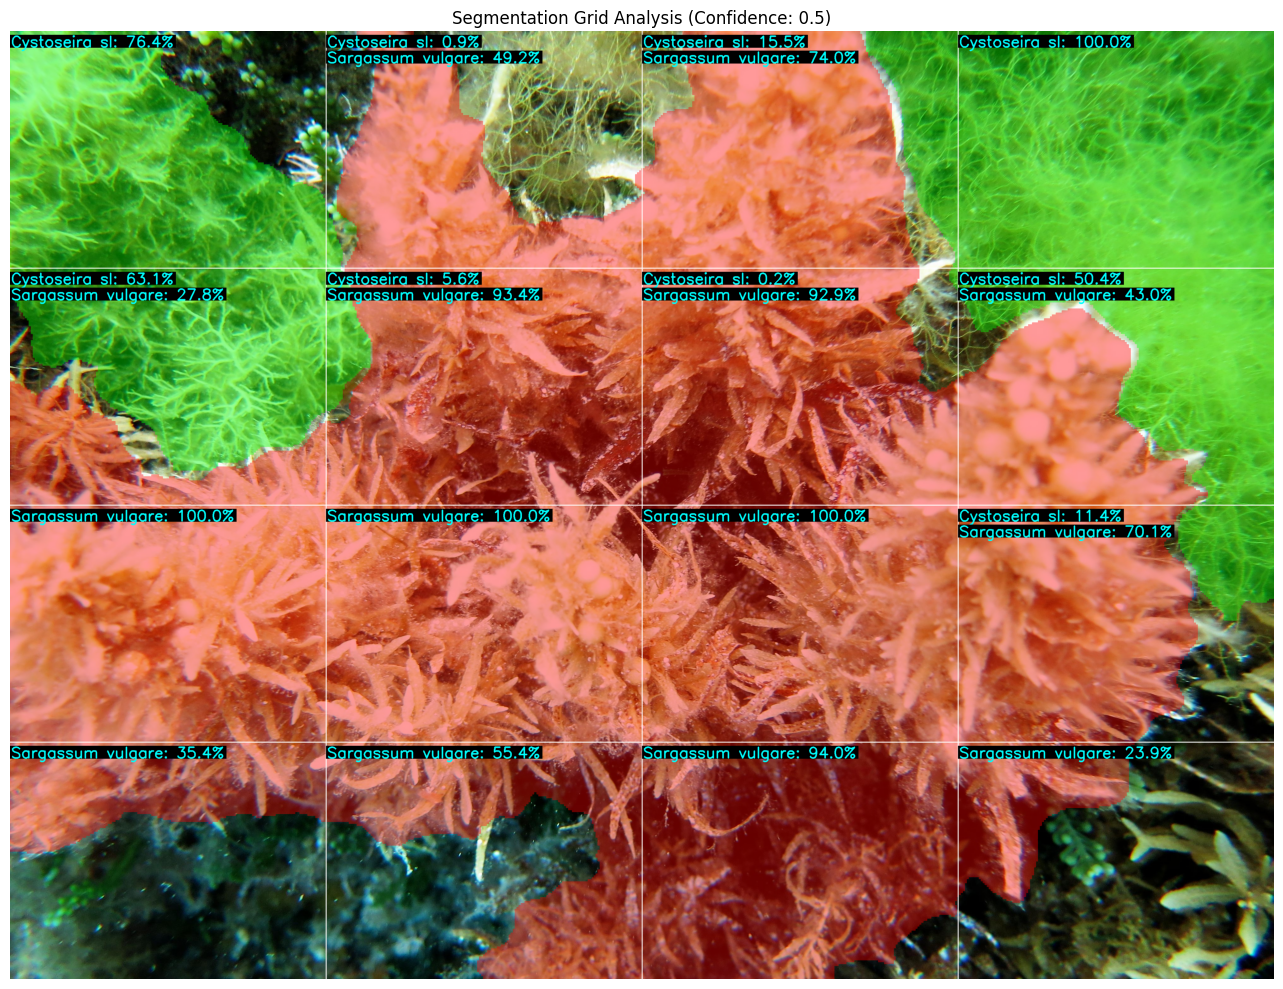

In [8]:
print("\nGenerating visualization...")
viz_img = visualize_results(img, GRID_SHAPE, grid_areas, grid_detections, class_masks, class_colors)

# Save visualization
cv.imwrite(OUTPUT_VIZ, viz_img)
print(f"Visualization saved to: {OUTPUT_VIZ}")

# Display
plt.figure(figsize=(14, 10))
plt.imshow(cv.cvtColor(viz_img, cv.COLOR_BGR2RGB))
plt.title(f"Segmentation Grid Analysis (Confidence: {CONFIDENCE_THRESHOLD})")
plt.axis("off")
plt.tight_layout()
plt.show()

#### EXPORT RESULTS

In [9]:
# Create Excel report
print("\nGenerating Excel report...")
df = create_excel_report(GRID_SHAPE, grid_areas, grid_detections, class_names.values(), OUTPUT_EXCEL)
print("\nWorkflow complete!")


Generating Excel report...
Excel report saved to: grid_analysis_report.xlsx

Workflow complete!


In [17]:
IMAGE_PATH = r"C:\Users\dolap\OneDrive\Documents\DOLAPO\data-analysis\photoquadrats_analysis\img\sample_img.JPG"
image = cv.imread(IMAGE_PATH)
print(image.shape[:2])
img_height, img_width = image.shape[:2]
rows, cols = GRID_SHAPE
row_height = img_height // rows
col_width = img_width // cols

(3000, 4000)


In [21]:
print(row_height, col_width)

750 1000
